In [14]:
import pandas as pd
import numpy as np
import fasttext
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.multioutput import MultiOutputClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    multilabel_confusion_matrix
)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
import argparse
import os
import json
from datetime import datetime
from tqdm import tqdm
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn import BCEWithLogitsLoss
from torch.optim import AdamW

In [15]:
def prepare_fasttext_data(df, text_column='all_text', output_file='fasttext_train.txt'):
    """
    Prepare data for FastText training by writing each text to a new line.
    """
    print(f"Preparing FastText training data from {text_column}...")
    
    # Filter out rows with 'nan' text
    df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    
    # Write texts to file
    with open(output_file, 'w', encoding='utf-8') as f:
        for text in tqdm(df[text_column]):
            f.write(text + '\n')
    
    print(f"Training data written to {output_file}")

In [27]:
def train_fasttext_model(input_file='fasttext_train.txt', model_path='fasttext_model.bin'):
    """
    Train a FastText model on the prepared data using GPU if available.
    """
    print("Training FastText model...")
    
    # Check if CUDA is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print(f"Using device: {device}")
    if device.type == "cuda":
        print(f"GPU: {torch.cuda.get_device_name(0)}")
    
    # Count total lines for progress bar
    total_lines = sum(1 for _ in open(input_file, 'r', encoding='utf-8'))
    print(f"Total training lines: {total_lines}")
    
    # Train the model with progress tracking
    print("Starting training process...")
    start_time = datetime.now()
    
    # Train the model
    model = fasttext.train_unsupervised(
        input_file,
        model='skipgram',
        dim=300,
        minCount=2,
        minn=3,
        maxn=6,
        lr=0.05,
        epoch=5,
        thread=4,
        verbose=1
    )
    
    end_time = datetime.now()
    training_duration = end_time - start_time
    print(f"\nTraining completed in {training_duration}")
    
    # Save the model
    print(f"Saving model to {model_path}...")
    model.save_model(model_path)
    print(f"Model saved successfully to {model_path}")
    
    # Print model information
    print("\nModel Information:")
    print(f"Vocabulary size: {len(model.get_words())}")
    print(f"Embedding dimension: {model.get_dimension()}")
    
    return model


In [17]:
def prepare_data(df, text_column='all_text', min_label_freq=0, max_label_len=100, min_label_comb_freq=0):
    """
    Filter out infrequent labels and samples with too many labels.
    """
    # Only keep text column and 'labels' columns
    if text_column in df.columns:
        df = df[[text_column, 'labels']]
        # Filter out rows with 'nan' text
        df = df[~df[text_column].apply(lambda x: x.startswith('nan') if isinstance(x, str) else False)]
    else:
        raise ValueError(f"Text column '{text_column}' not found in the DataFrame. Available columns: {df.columns.tolist()}")
    
    # Drop rows with missing labels
    df = df.dropna()
    
    # Extract issue texts and labels
    texts = df[text_column]
    labels = df['labels'].apply(lambda x: x if isinstance(x, list) else [])  # Ensure labels are lists

    # Get labels count distribution
    label_distribution = Counter([label for labels in labels for label in labels])

    # Labels to keep based on frequency
    frequent_labels = [label for label, count in label_distribution.items() if count >= min_label_freq]
    print(f"Number of labels with at least {min_label_freq} occurrences: {len(frequent_labels)}")
    print(f"Removed {len(label_distribution) - len(frequent_labels)} infrequent labels")

    # Filter out infrequent labels
    filtered_labels = labels.apply(lambda x: [label for label in x if label in frequent_labels])
    print(f"Number of samples after filtering: {len(filtered_labels)}")

    # Get label combinations distribution
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    frequent_combinations = {labels: count for labels, count in label_combinations.items() if count >= min_label_comb_freq}
    print(f"Number of label combinations with at least {min_label_comb_freq} occurrences: {len(frequent_combinations)}")
    print(f"Removed {len(label_combinations) - len(frequent_combinations)} infrequent label combinations")
    
    # Create mask for samples with frequent label combinations
    if min_label_comb_freq > 0:
        comb_mask = filtered_labels.apply(lambda x: tuple(sorted(x)) in frequent_combinations)
        print(f"Number of samples with frequent label combinations: {comb_mask.sum()}")
    else:
        comb_mask = pd.Series([True] * len(filtered_labels))
    
    # Filter by label length
    label_length = filtered_labels.apply(len)
    length_mask = (label_length > 0) & (label_length <= max_label_len)
    
    # Combine both masks
    final_mask = comb_mask & length_mask
    
    # Now get the final filtered texts and labels
    texts = texts[final_mask].reset_index(drop=True)
    filtered_labels = filtered_labels[final_mask].reset_index(drop=True)
    
    print(f"Final number of samples after all filtering: {len(filtered_labels)}")
    
    return texts, filtered_labels


In [18]:
def plot_multilabel_confusion_matrix(y_true, y_pred, class_names, model_name):
    """
    Plot confusion matrices for each label in a multi-label classification problem.
    """
    confusion_matrices = multilabel_confusion_matrix(y_true, y_pred)
    
    num_classes = len(class_names)
    fig, axes = plt.subplots(nrows=(num_classes + 3) // 4, ncols=min(4, num_classes), 
                             figsize=(20, 5 * ((num_classes + 3) // 4)))
    if num_classes == 1:
        axes = np.array([axes])
    axes = axes.flatten()
    
    for i, matrix in enumerate(confusion_matrices):
        if i < num_classes:
            ax = axes[i]
            sns.heatmap(matrix, annot=True, fmt='d', cmap='Blues', ax=ax)
            ax.set_title(f'Label: {class_names[i]}')
            ax.set_xlabel('Predicted')
            ax.set_ylabel('True')
            ax.set_xticklabels(['Negative', 'Positive'])
            ax.set_yticklabels(['Negative', 'Positive'])
    
    for i in range(num_classes, len(axes)):
        fig.delaxes(axes[i])
        
    plt.suptitle(f'Confusion Matrices for {model_name}')
    plt.tight_layout()
    return fig

In [19]:
def get_fasttext_embeddings(texts, model, batch_size=32):
    """
    Get FastText embeddings for a list of texts in batches.
    """
    embeddings = []
    
    for i in tqdm(range(0, len(texts), batch_size), desc="Generating embeddings"):
        batch_texts = texts[i:i + batch_size].tolist()
        
        # Get embeddings for each text in the batch
        batch_embeddings = [model.get_word_vector(text) for text in batch_texts]
        embeddings.extend(batch_embeddings)
    
    return np.array(embeddings)

In [20]:
def calculate_metrics(y_true, y_pred):
    """
    Calculate all relevant metrics for multi-label classification.
    """
    exact_match = (y_pred == y_true).all(axis=1).mean()
    
    # Calculate partial match accuracy
    true_positives = np.logical_and(y_pred == 1, y_true == 1).sum(axis=1)
    total_positives = (y_true == 1).sum(axis=1)
    partial_match = np.zeros_like(true_positives, dtype=float)
    mask = total_positives > 0
    partial_match[mask] = true_positives[mask] / total_positives[mask]
    partial_match_accuracy = partial_match.mean()
    
    # Calculate Jaccard similarity
    def jaccard_score(y_true, y_pred):
        intersection = np.logical_and(y_true, y_pred).sum(axis=1)
        union = np.logical_or(y_true, y_pred).sum(axis=1)
        result = np.zeros_like(intersection, dtype=float)
        np.divide(intersection, union, out=result, where=union!=0)
        return np.mean(result)
    
    jaccard_sim = jaccard_score(y_true, y_pred)
    
    # Calculate sample-based metrics
    precision = precision_score(y_true, y_pred, average='samples', zero_division=0)
    recall = recall_score(y_true, y_pred, average='samples', zero_division=0)
    f1 = f1_score(y_true, y_pred, average='samples', zero_division=0)
    
    return {
        'exact_match': float(exact_match),
        'partial_match': float(partial_match_accuracy),
        'jaccard': float(jaccard_sim),
        'precision': float(precision),
        'recall': float(recall),
        'f1': float(f1)
    }

In [21]:
def train_and_evaluate_model(model, train_embeddings, train_labels, val_embeddings, val_labels, model_name, run_dir, mlb):
    """
    Train and evaluate a single model, saving results and visualizations.
    """
    print(f"\nTraining {model_name}...")
    model.fit(train_embeddings, train_labels)
    
    print(f"Making predictions with {model_name}...")
    val_preds = model.predict(val_embeddings)
    
    # Calculate metrics
    metrics = calculate_metrics(val_labels, val_preds)
    
    # Print metrics
    print(f"\n{model_name} Validation Metrics:")
    for metric_name, value in metrics.items():
        print(f"{metric_name}: {value:.4f}")
    
    # Plot and save confusion matrices
    num_labels_to_plot = min(20, len(mlb.classes_))
    fig = plot_multilabel_confusion_matrix(
        val_labels[:, :num_labels_to_plot], 
        val_preds[:, :num_labels_to_plot], 
        mlb.classes_[:num_labels_to_plot],
        model_name
    )
    plt.savefig(os.path.join(run_dir, f'confusion_matrices_{model_name.lower().replace(" ", "_")}.png'))
    
    # If it's Random Forest, save feature importances
    if isinstance(model, RandomForestClassifier):
        feature_importances = model.feature_importances_
        plt.figure(figsize=(10, 5))
        plt.bar(range(len(feature_importances)), feature_importances)
        plt.title(f'Feature Importances for {model_name}')
        plt.xlabel('Feature Index')
        plt.ylabel('Importance')
        plt.savefig(os.path.join(run_dir, f'feature_importances_{model_name.lower().replace(" ", "_")}.png'))
    
    return metrics

In [22]:
def normalize_embeddings(embeddings):
    """
    Normalize embeddings to be non-negative and sum to 1 for each sample.
    This is required for MultinomialNB which expects non-negative features.
    """
    # Shift to non-negative values
    min_val = np.min(embeddings)
    if min_val < 0:
        embeddings = embeddings - min_val
    
    # Normalize to sum to 1
    row_sums = np.sum(embeddings, axis=1, keepdims=True)
    embeddings = embeddings / row_sums
    
    return embeddings


In [23]:
def filter_labels_with_diversity(train_labels, val_labels, min_classes=2):
    """
    Filter out labels that don't have enough class diversity in either training or validation set.
    Returns a mask indicating which labels to keep.
    """
    # Calculate the number of unique classes for each label in both sets
    train_unique_classes = np.array([len(np.unique(train_labels[:, i])) for i in range(train_labels.shape[1])])
    val_unique_classes = np.array([len(np.unique(val_labels[:, i])) for i in range(val_labels.shape[1])])
    
    # Create mask for labels with sufficient diversity in both sets
    mask = (train_unique_classes >= min_classes) & (val_unique_classes >= min_classes)
    
    # Print information about filtered labels
    filtered_indices = np.where(~mask)[0]
    if len(filtered_indices) > 0:
        print(f"\nFiltered out {len(filtered_indices)} labels with insufficient class diversity:")
        for idx in filtered_indices:
            train_unique = np.unique(train_labels[:, idx])
            val_unique = np.unique(val_labels[:, idx])
            print(f"Label {idx}:")
            print(f"  Training set classes: {train_unique}")
            print(f"  Validation set classes: {val_unique}")
    
    return mask


In [24]:
class CustomStackingClassifier(StackingClassifier):
    def __init__(self, estimators, final_estimator, cv=5, stack_method='predict_proba', n_jobs=None):
        # Initialize base class
        super().__init__(estimators, final_estimator, cv=cv, stack_method=stack_method, n_jobs=n_jobs)
        
        # Initialize required attributes
        self.estimators_ = []
        self.named_estimators_ = {}
        self.final_estimator_ = final_estimator
        
        # Store estimators with their names
        for name, estimator in self.estimators:
            self.named_estimators_[name] = estimator
    
    def fit(self, X, y, **fit_params):
        # Normalize embeddings for MultinomialNB
        X_nb = normalize_embeddings(X)
        
        # Fit base estimators with appropriate embeddings
        for name, estimator in self.named_estimators_.items():
            if name == 'nb':
                estimator.fit(X_nb, y)
            else:
                estimator.fit(X, y)
        
        # Get predictions from base estimators
        meta_features = []
        for name, estimator in self.named_estimators_.items():
            X_curr = X_nb if name == 'nb' else X
            probas = estimator.predict_proba(X_curr)
            # For multi-label, probas is a list of arrays
            # We need to extract the positive class probability for each label
            meta_features.extend([proba[:, 1] for proba in probas])
        
        X_meta = np.column_stack(meta_features)
        
        # Fit final estimator
        self.final_estimator_.fit(X_meta, y)
        return self
    
    def predict(self, X):
        # Normalize embeddings for MultinomialNB
        X_nb = normalize_embeddings(X)
        
        # Get predictions from base estimators
        meta_features = []
        for name, estimator in self.named_estimators_.items():
            X_curr = X_nb if name == 'nb' else X
            probas = estimator.predict_proba(X_curr)
            # For multi-label, probas is a list of arrays
            # We need to extract the positive class probability for each label
            meta_features.extend([proba[:, 1] for proba in probas])
        
        X_meta = np.column_stack(meta_features)
        
        return self.final_estimator_.predict(X_meta)
    
    def predict_proba(self, X):
        # Normalize embeddings for MultinomialNB
        X_nb = normalize_embeddings(X)
        
        # Get predictions from base estimators
        meta_features = []
        for name, estimator in self.named_estimators_.items():
            X_curr = X_nb if name == 'nb' else X
            probas = estimator.predict_proba(X_curr)
            # For multi-label, probas is a list of arrays
            # We need to extract the positive class probability for each label
            meta_features.extend([proba[:, 1] for proba in probas])
        
        X_meta = np.column_stack(meta_features)
        
        return self.final_estimator_.predict_proba(X_meta)


In [25]:
def main(args):
    """
    Main function to run the multi-label classification pipeline with multiple ML models using FastText embeddings.
    """
    # Set random seeds for reproducibility
    np.random.seed(42)
    torch.manual_seed(42)
    
    # Make results directory if it doesn't exist
    results_dir = args.results_dir
    os.makedirs(results_dir, exist_ok=True)
    
    # Create a timestamped directory for this run
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    run_dir = os.path.join(results_dir, f"run_{timestamp}_{args.text_column}")
    os.makedirs(run_dir, exist_ok=True)
    
    # Load data
    print(f"Loading data from {args.data_path}...")
    df = pd.read_json(args.data_path)
    
    # Check if the text column exists
    if args.text_column not in df.columns:
        available_columns = [col for col in df.columns if col.startswith('all_text')]
        print(f"Text column '{args.text_column}' not found. Available text columns: {available_columns}")
        if len(available_columns) == 0:
            raise ValueError("No text columns found in the data")
        args.text_column = available_columns[0]
        print(f"Using '{args.text_column}' instead")
    
    # Train FastText model if not provided
    if not os.path.exists(args.fasttext_model_path):
        print("FastText model not found. Training new model...")
        prepare_fasttext_data(df, args.text_column)
        model = train_fasttext_model(model_path=args.fasttext_model_path)
    else:
        print("Loading existing FastText model...")
        model = fasttext.load_model(args.fasttext_model_path)
    
    # Use prepare_data function to filter and prepare data
    texts, filtered_labels = prepare_data(
        df, 
        text_column=args.text_column,
        min_label_freq=args.min_label_freq, 
        max_label_len=args.max_label_len, 
        min_label_comb_freq=args.min_label_comb_freq
    )
    
    # Count the number of labels distribution
    label_distribution = Counter([label for labels in filtered_labels for label in labels])
    print('\n Label Distribution : ')
    for i, (label, count) in enumerate(sorted(label_distribution.items(), key=lambda x: x[1], reverse=True)):
        print(f'{i}. {label}: {count}')
    
    # Count the label length distribution
    label_length_distribution = Counter([len(labels) for labels in filtered_labels])
    print('\n Label count per row distribution:')
    for label in sorted(label_length_distribution.keys()):
        print(f'Label: {label}, count: {label_length_distribution[label]}')

    # Count the distribution of label combinations
    label_combinations = Counter([tuple(sorted(labels)) for labels in filtered_labels])
    print('\n Label combinations distribution:')
    for i, (labels, count) in enumerate(sorted(label_combinations.items(), key=lambda x: x[1], reverse=True)):
        if i < 20:  # Show only the top 20 combinations
            print(f'{i}. Label combination: {labels}, count: {count}')
    
    # Encode multi-labels using MultiLabelBinarizer
    print("Encoding labels...")
    mlb = MultiLabelBinarizer()
    labels_encoded = mlb.fit_transform(filtered_labels)
    
    # Split data into training and validation sets (80% training, 20% validation)
    split_idx = int(len(texts) * 0.8)
    train_texts, val_texts = texts[:split_idx], texts[split_idx:]
    train_labels, val_labels = labels_encoded[:split_idx], labels_encoded[split_idx:]
    
    print(f"\nTraining samples: {len(train_texts)}, Validation samples: {len(val_texts)}")
    
    # Filter out labels with insufficient class diversity in either set
    print("\nChecking label diversity in training and validation sets...")
    diversity_mask = filter_labels_with_diversity(train_labels, val_labels)
    train_labels = train_labels[:, diversity_mask]
    val_labels = val_labels[:, diversity_mask]
    mlb.classes_ = mlb.classes_[diversity_mask]
    
    # Save label encoder for future use
    with open(os.path.join(run_dir, 'label_encoder.json'), 'w') as f:
        json.dump({
            'classes': mlb.classes_.tolist()
        }, f)
    
    # Calculate label distribution
    label_counts = train_labels.sum(axis=0)
    
    # Log class imbalance metrics
    label_density = label_counts.sum() / (train_labels.shape[0] * train_labels.shape[1])
    print(f"\nLabel density: {label_density:.4f}")
    print(f"Average labels per sample: {label_counts.sum() / train_labels.shape[0]:.2f}")
    print(f"Total number of unique labels: {len(mlb.classes_)}")
    
    # Generate embeddings for training and validation sets
    print("\nGenerating embeddings with FastText...")
    train_embeddings = get_fasttext_embeddings(train_texts, model, batch_size=args.batch_size)
    val_embeddings = get_fasttext_embeddings(val_texts, model, batch_size=args.batch_size)
    
    # Normalize embeddings for MultinomialNB
    train_embeddings_nb = normalize_embeddings(train_embeddings)
    val_embeddings_nb = normalize_embeddings(val_embeddings)
    
    # Initialize models
    models = {
        'Naive Bayes': MultiOutputClassifier(MultinomialNB(), n_jobs=-1),
        'Logistic Regression': MultiOutputClassifier(
            LogisticRegression(
                max_iter=1000,
                n_jobs=-1,
                random_state=42
            ),
            n_jobs=-1
        ),
        'Random Forest': MultiOutputClassifier(
            RandomForestClassifier(
                n_estimators=args.n_estimators,
                max_depth=args.max_depth,
                min_samples_split=args.min_samples_split,
                min_samples_leaf=args.min_samples_leaf,
                n_jobs=-1,
                random_state=42
            ),
            n_jobs=-1
        )
    }
    
    # Train and evaluate each model
    all_metrics = {}
    for model_name, model in models.items():
        # Use normalized embeddings for Naive Bayes, original embeddings for others
        train_emb = train_embeddings_nb if model_name == 'Naive Bayes' else train_embeddings
        val_emb = val_embeddings_nb if model_name == 'Naive Bayes' else val_embeddings
        
        metrics = train_and_evaluate_model(
            model, train_emb, train_labels, 
            val_emb, val_labels, model_name, run_dir, mlb
        )
        all_metrics[model_name] = metrics
    
    # Create and evaluate stacking classifier
    print("\nTraining Stacking Classifier...")
    
    # Create base estimators with normalized embeddings for MultinomialNB
    base_estimators = [
        ('nb', MultiOutputClassifier(MultinomialNB(), n_jobs=-1)),
        ('lr', MultiOutputClassifier(
            LogisticRegression(
                max_iter=1000,
                n_jobs=-1,
                random_state=42
            ),
            n_jobs=-1
        )),
        ('rf', MultiOutputClassifier(
            RandomForestClassifier(
                n_estimators=args.n_estimators,
                max_depth=args.max_depth,
                min_samples_split=args.min_samples_split,
                min_samples_leaf=args.min_samples_leaf,
                n_jobs=-1,
                random_state=42
            ),
            n_jobs=-1
        ))
    ]
    
    # Create final estimator
    final_estimator = MultiOutputClassifier(
        LogisticRegression(max_iter=1000, n_jobs=-1, random_state=42),
        n_jobs=-1
    )
    
    # Create and fit the custom stacking classifier
    stacking_model = CustomStackingClassifier(
        base_estimators,
        final_estimator,
        cv=5,
        stack_method='predict_proba',
        n_jobs=-1
    )
    
    # Use original embeddings for stacking classifier (normalization is handled internally)
    stacking_metrics = train_and_evaluate_model(
        stacking_model, train_embeddings, train_labels, 
        val_embeddings, val_labels, 'Stacking Classifier', run_dir, mlb
    )
    all_metrics['Stacking Classifier'] = stacking_metrics
    
    # Save all results
    results = {
        'text_column': args.text_column,
        'metrics': all_metrics,
        'fasttext_model': args.fasttext_model_path
    }
    with open(os.path.join(run_dir, 'results.json'), 'w') as f:
        json.dump(results, f, indent=4)
    
    # Create comparison plot
    metrics_to_plot = ['exact_match', 'partial_match', 'jaccard', 'precision', 'recall', 'f1']
    plt.figure(figsize=(15, 8))
    x = np.arange(len(models) + 1)  # +1 for stacking classifier
    width = 0.15
    
    for i, metric in enumerate(metrics_to_plot):
        values = [all_metrics[model][metric] for model in models] + [all_metrics['Stacking Classifier'][metric]]
        plt.bar(x + i*width, values, width, label=metric)
    
    plt.xlabel('Models')
    plt.ylabel('Score')
    plt.title('Model Comparison')
    plt.xticks(x + width*2.5, list(models.keys()) + ['Stacking'], rotation=45)
    plt.legend()
    plt.tight_layout()
    plt.savefig(os.path.join(run_dir, 'model_comparison.png'))
    
    print(f"\nTraining completed! Results saved to {run_dir}")
    
    return {
        'metrics': all_metrics,
        'models': {**models, 'Stacking Classifier': stacking_model},
        'fasttext_model': model,
        'label_encoder': mlb,
        'results_dir': run_dir
    }

In [28]:
ls -al

total 1768
drwxr-xr-x 4 root root    4096 Mar 18 11:39 ./
drwxr-xr-x 5 root root    4096 Mar 18 11:38 ../
-rw-r--r-- 1 root root 1790016 Mar 18 11:39 fasttext_train.txt
drwxr-xr-x 4 root root    4096 Mar 18 11:39 results/
drwxr-xr-x 2 root root    4096 Mar 18 11:38 .virtual_documents/


In [30]:
pwd

'/kaggle/working'

In [32]:
rm -r '/fasttext_model.bin'

rm: cannot remove '/fasttext_model.bin': No such file or directory


Loading data from /kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json...
FastText model not found. Training new model...
Preparing FastText training data from all_text_0.5...


100%|██████████| 1258/1258 [00:00<00:00, 343629.73it/s]

Training data written to fasttext_train.txt
Training FastText model...
Using device: cuda
GPU: Tesla T4
Total training lines: 1258
Starting training process...



Training completed in 0:00:30.085508
Saving model to fasttext_model.bin...
Model saved successfully to fasttext_model.bin

Model Information:
Vocabulary size: 8292
Embedding dimension: 300
Number of labels with at least 5 occurrences: 20
Removed 19 infrequent labels
Number of samples after filtering: 1258
Number of label combinations with at least 2 occurrences: 52
Removed 57 infrequent label combinations
Number of samples with frequent label combinations: 1201
Final number of samples after all filtering: 1177

 Label Distribution : 
0. area/kubelet: 358
1. area/test: 303
2. area/apiserver: 209
3. area/cloudprovider: 183
4. area/kubectl: 135
5. area/provider/azure: 66
6. area/dependency: 64
7. area/code-generation: 48
8. area/ipvs: 44
9. area/kubeadm: 39
10. area/kube-proxy: 27
11. area/provider/gcp: 22
12. area/e2e-test-framework: 17
13. area/conformance: 16
14. area/custom-resources: 15
15. area/release-eng: 14
16. area/security: 10
17. area/etcd: 5
18. area/provider/openstack: 5
19

Generating embeddings: 100%|██████████| 8/8 [00:00<00:00, 23.04it/s]



Training Naive Bayes...
Making predictions with Naive Bayes...

Naive Bayes Validation Metrics:
exact_match: 0.0212
partial_match: 0.0000
jaccard: 0.0000
precision: 0.0000
recall: 0.0000
f1: 0.0000

Training Logistic Regression...
Making predictions with Logistic Regression...

Logistic Regression Validation Metrics:
exact_match: 0.2712
partial_match: 0.3966
jaccard: 0.3465
precision: 0.3863
recall: 0.3966
f1: 0.3767

Training Random Forest...
Making predictions with Random Forest...

Random Forest Validation Metrics:
exact_match: 0.3347
partial_match: 0.4701
jaccard: 0.4149
precision: 0.4590
recall: 0.4701
f1: 0.4474

Training Stacking Classifier...

Training Stacking Classifier...
Making predictions with Stacking Classifier...

Stacking Classifier Validation Metrics:
exact_match: 0.3220
partial_match: 0.4460
jaccard: 0.3980
precision: 0.4420
recall: 0.4460
f1: 0.4282

Training completed! Results saved to ./results/run_20250318_114124_all_text_0.5


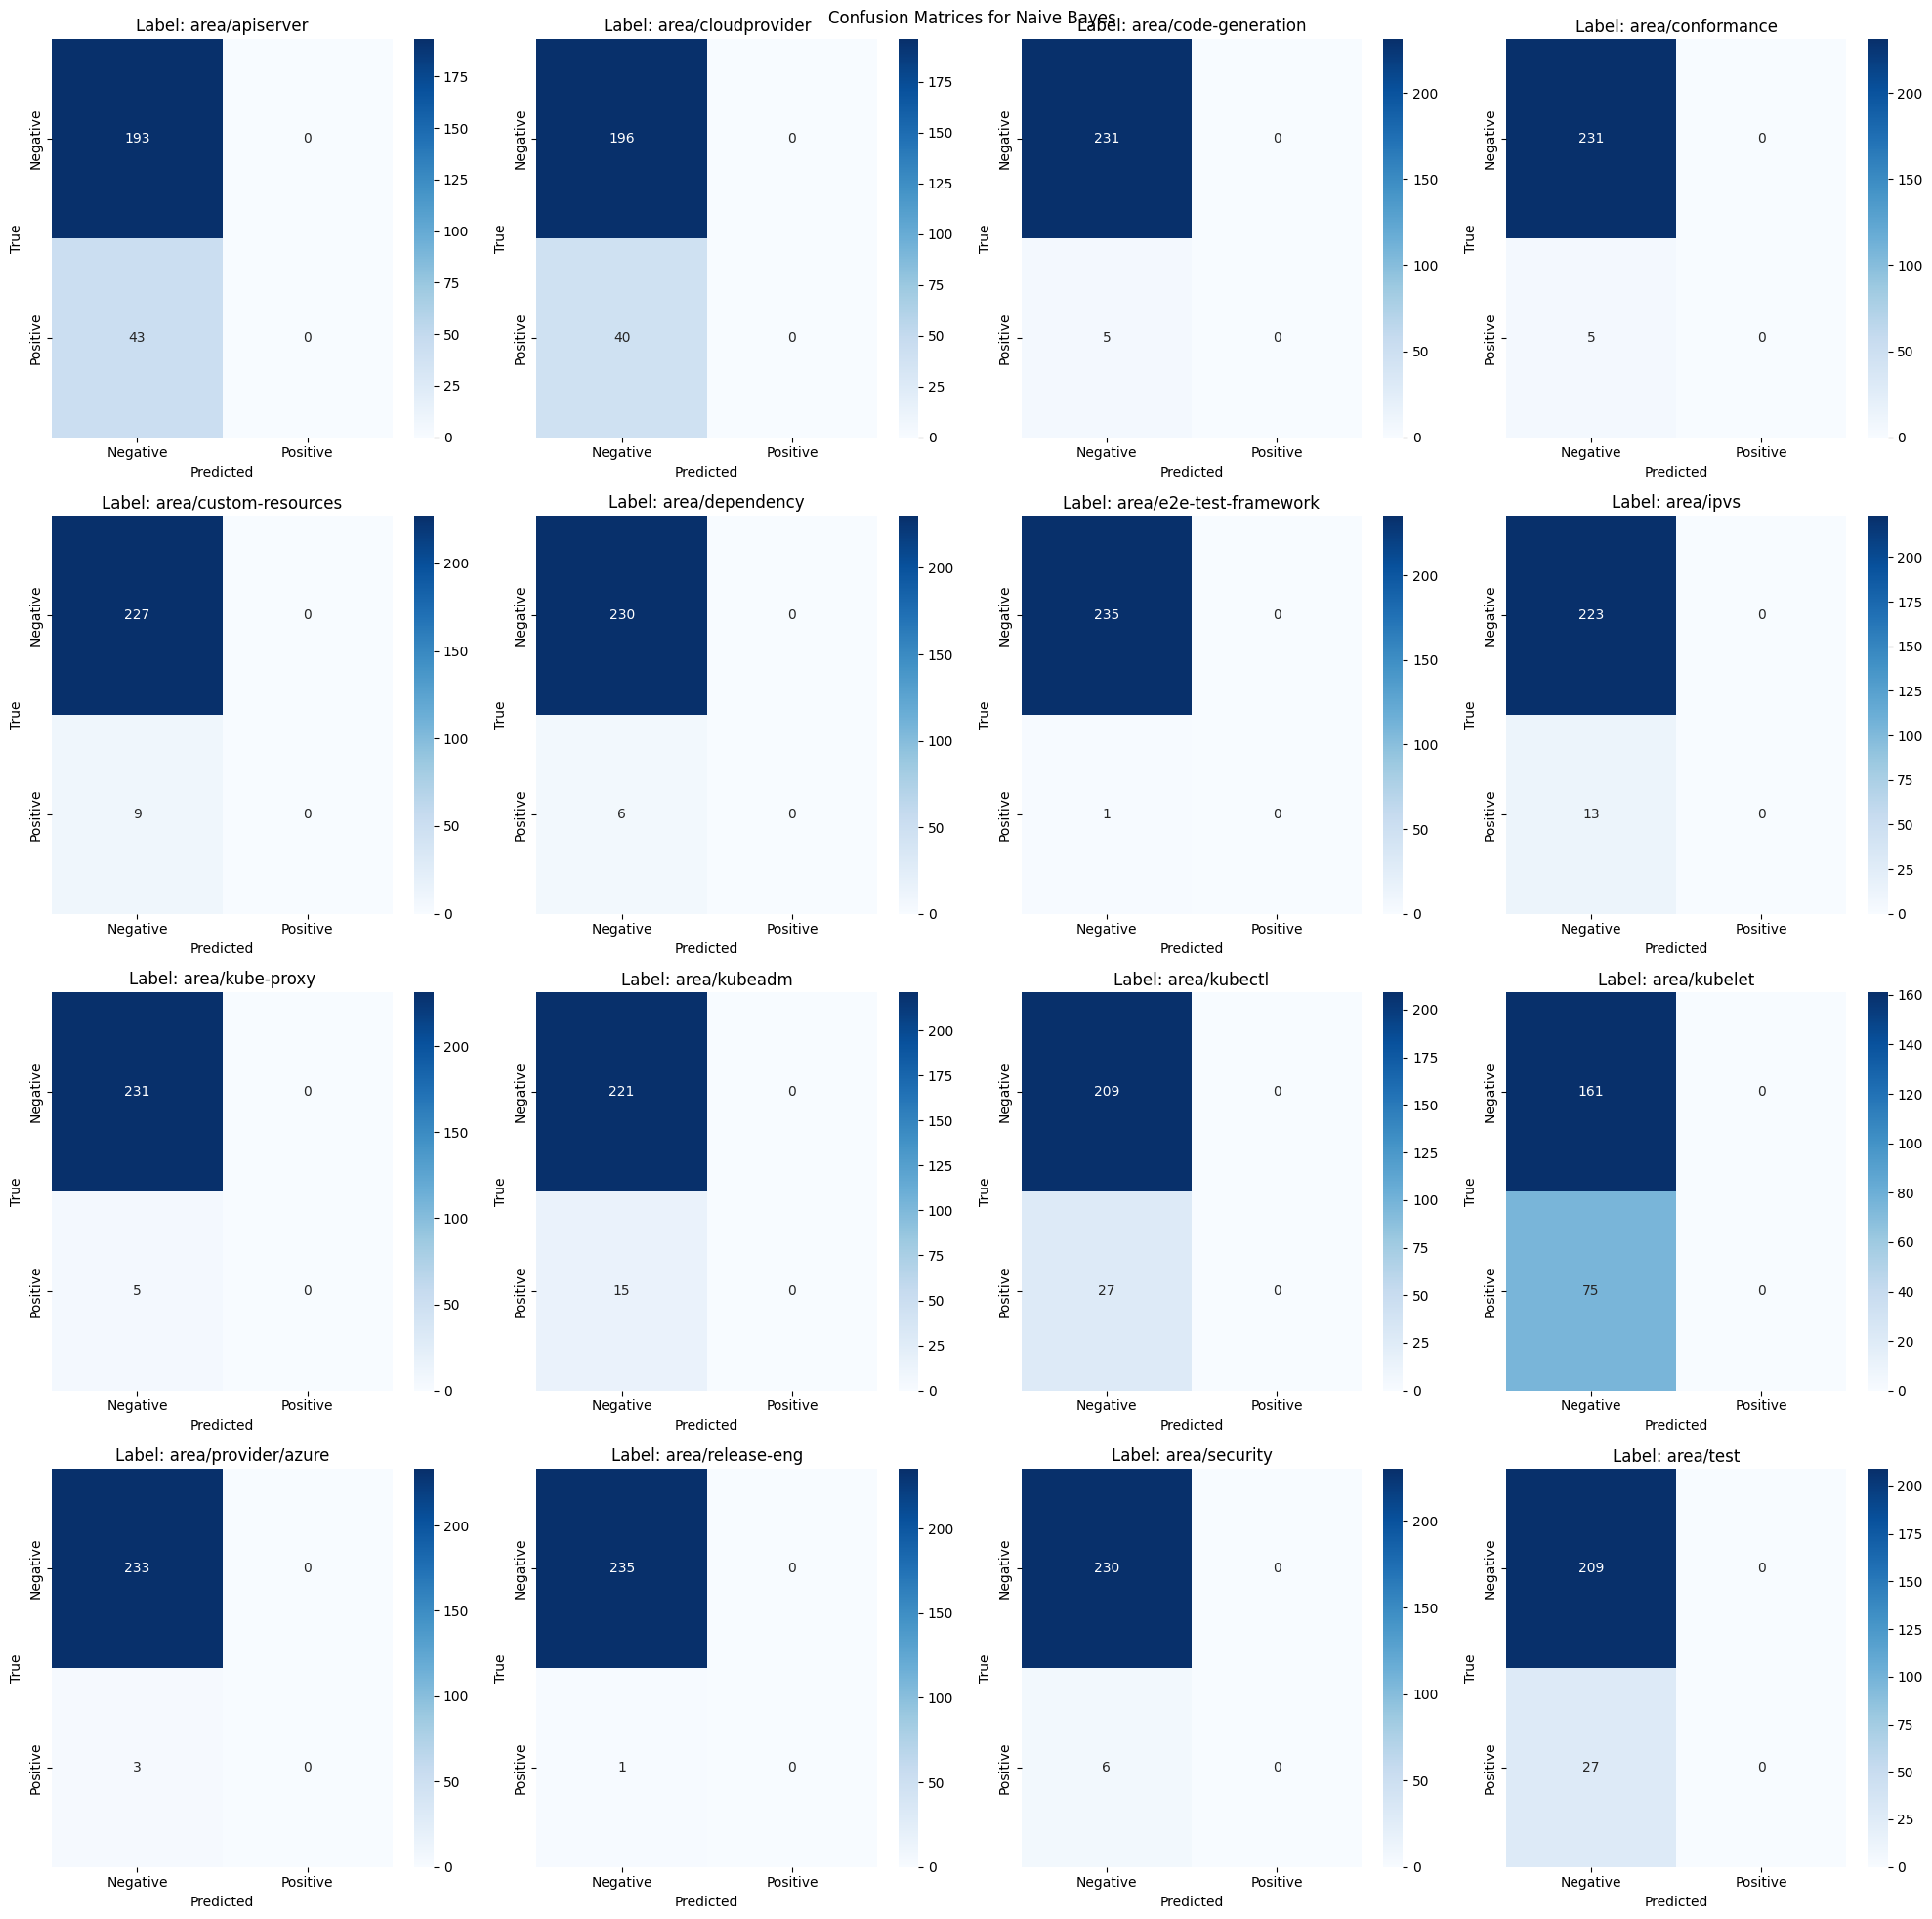

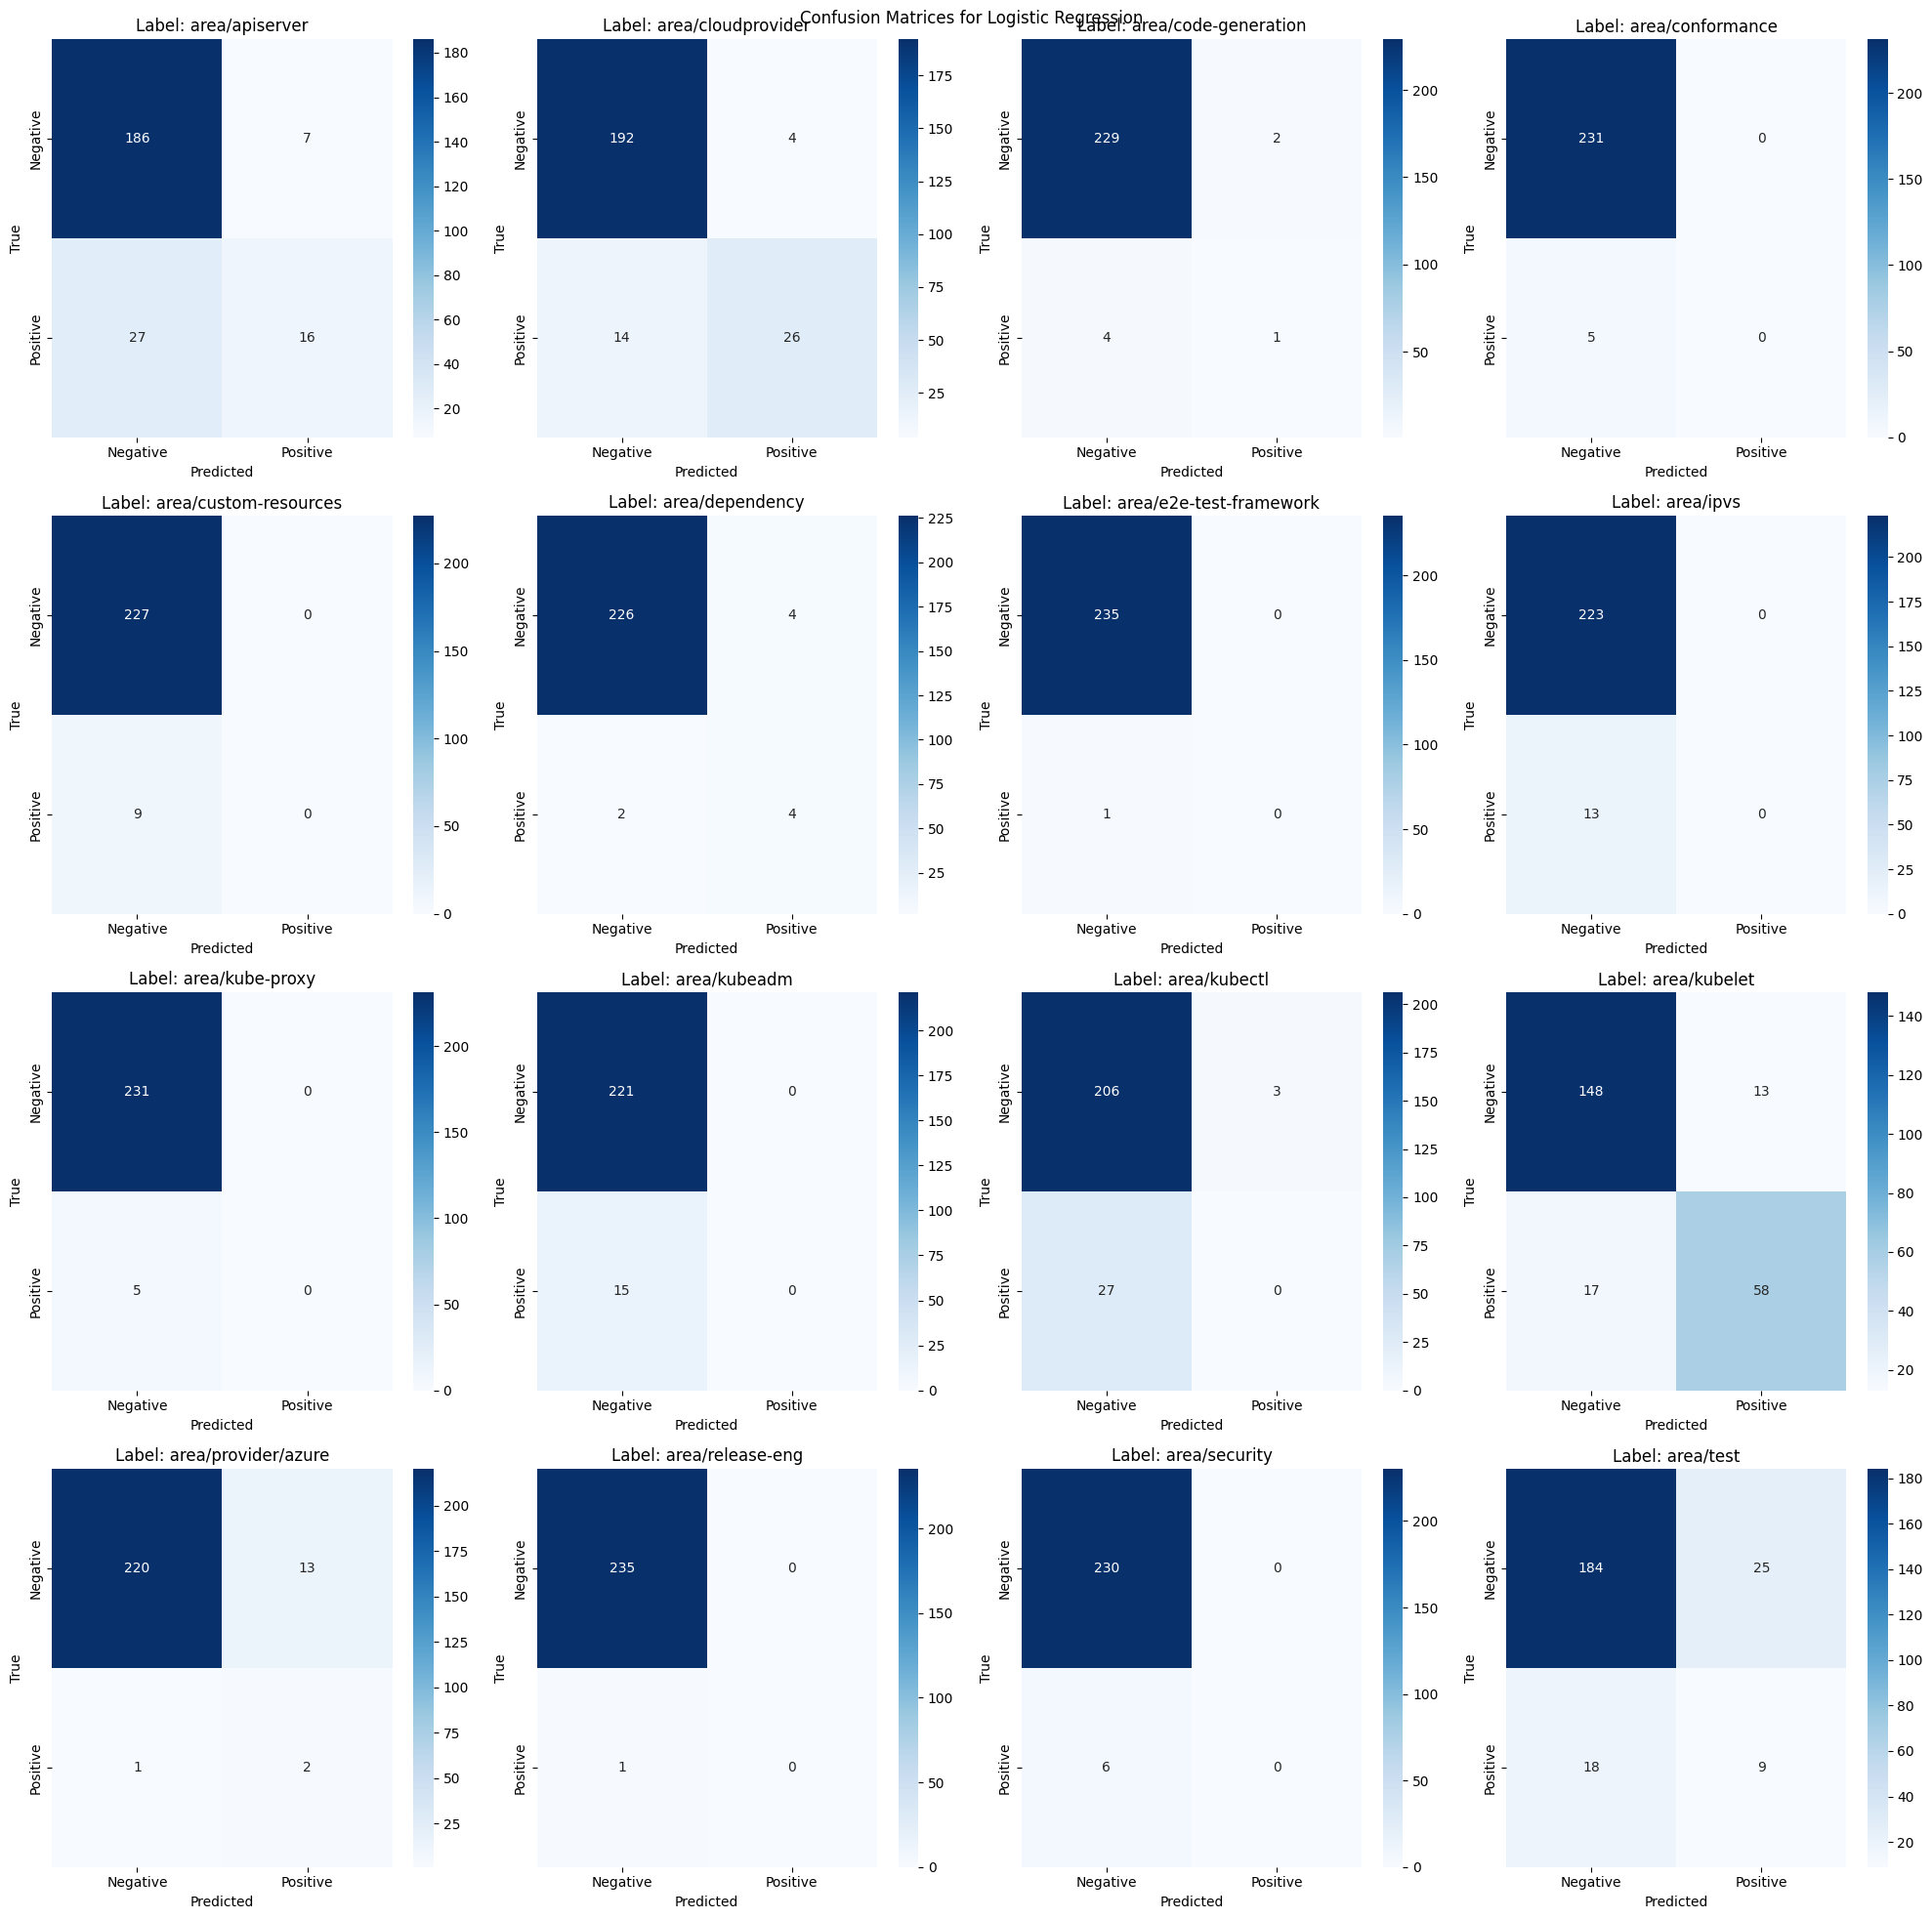

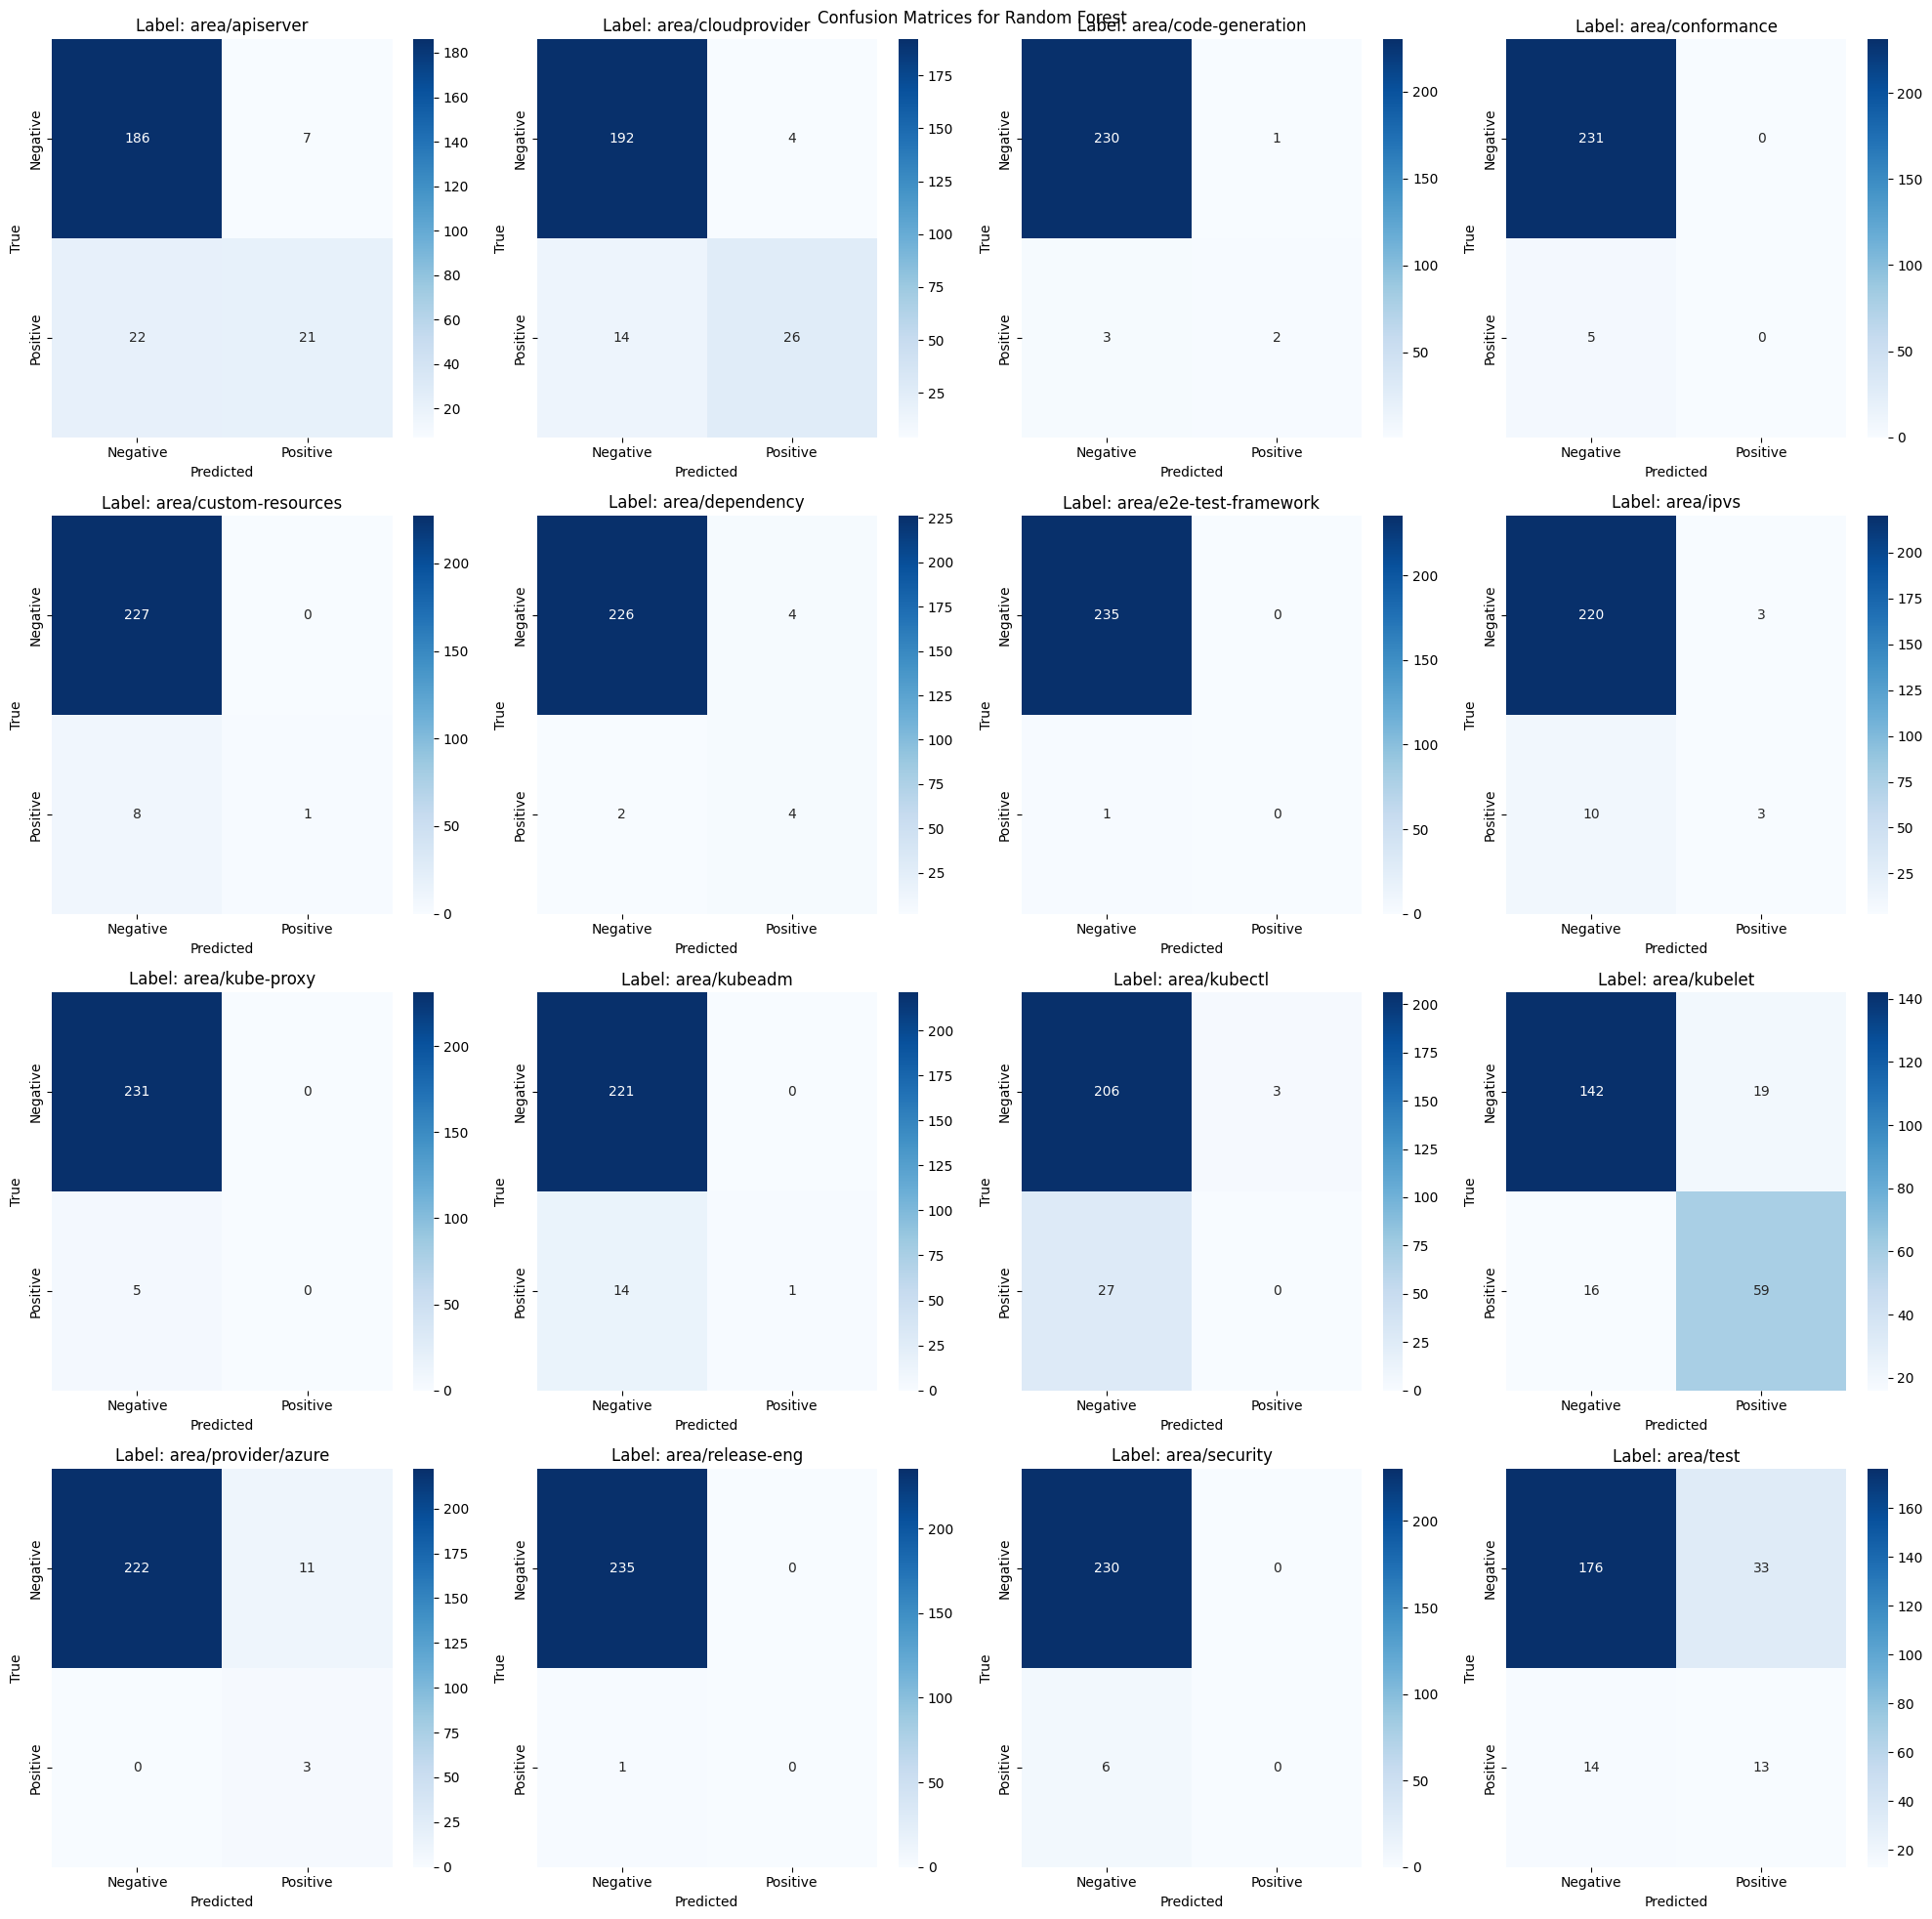

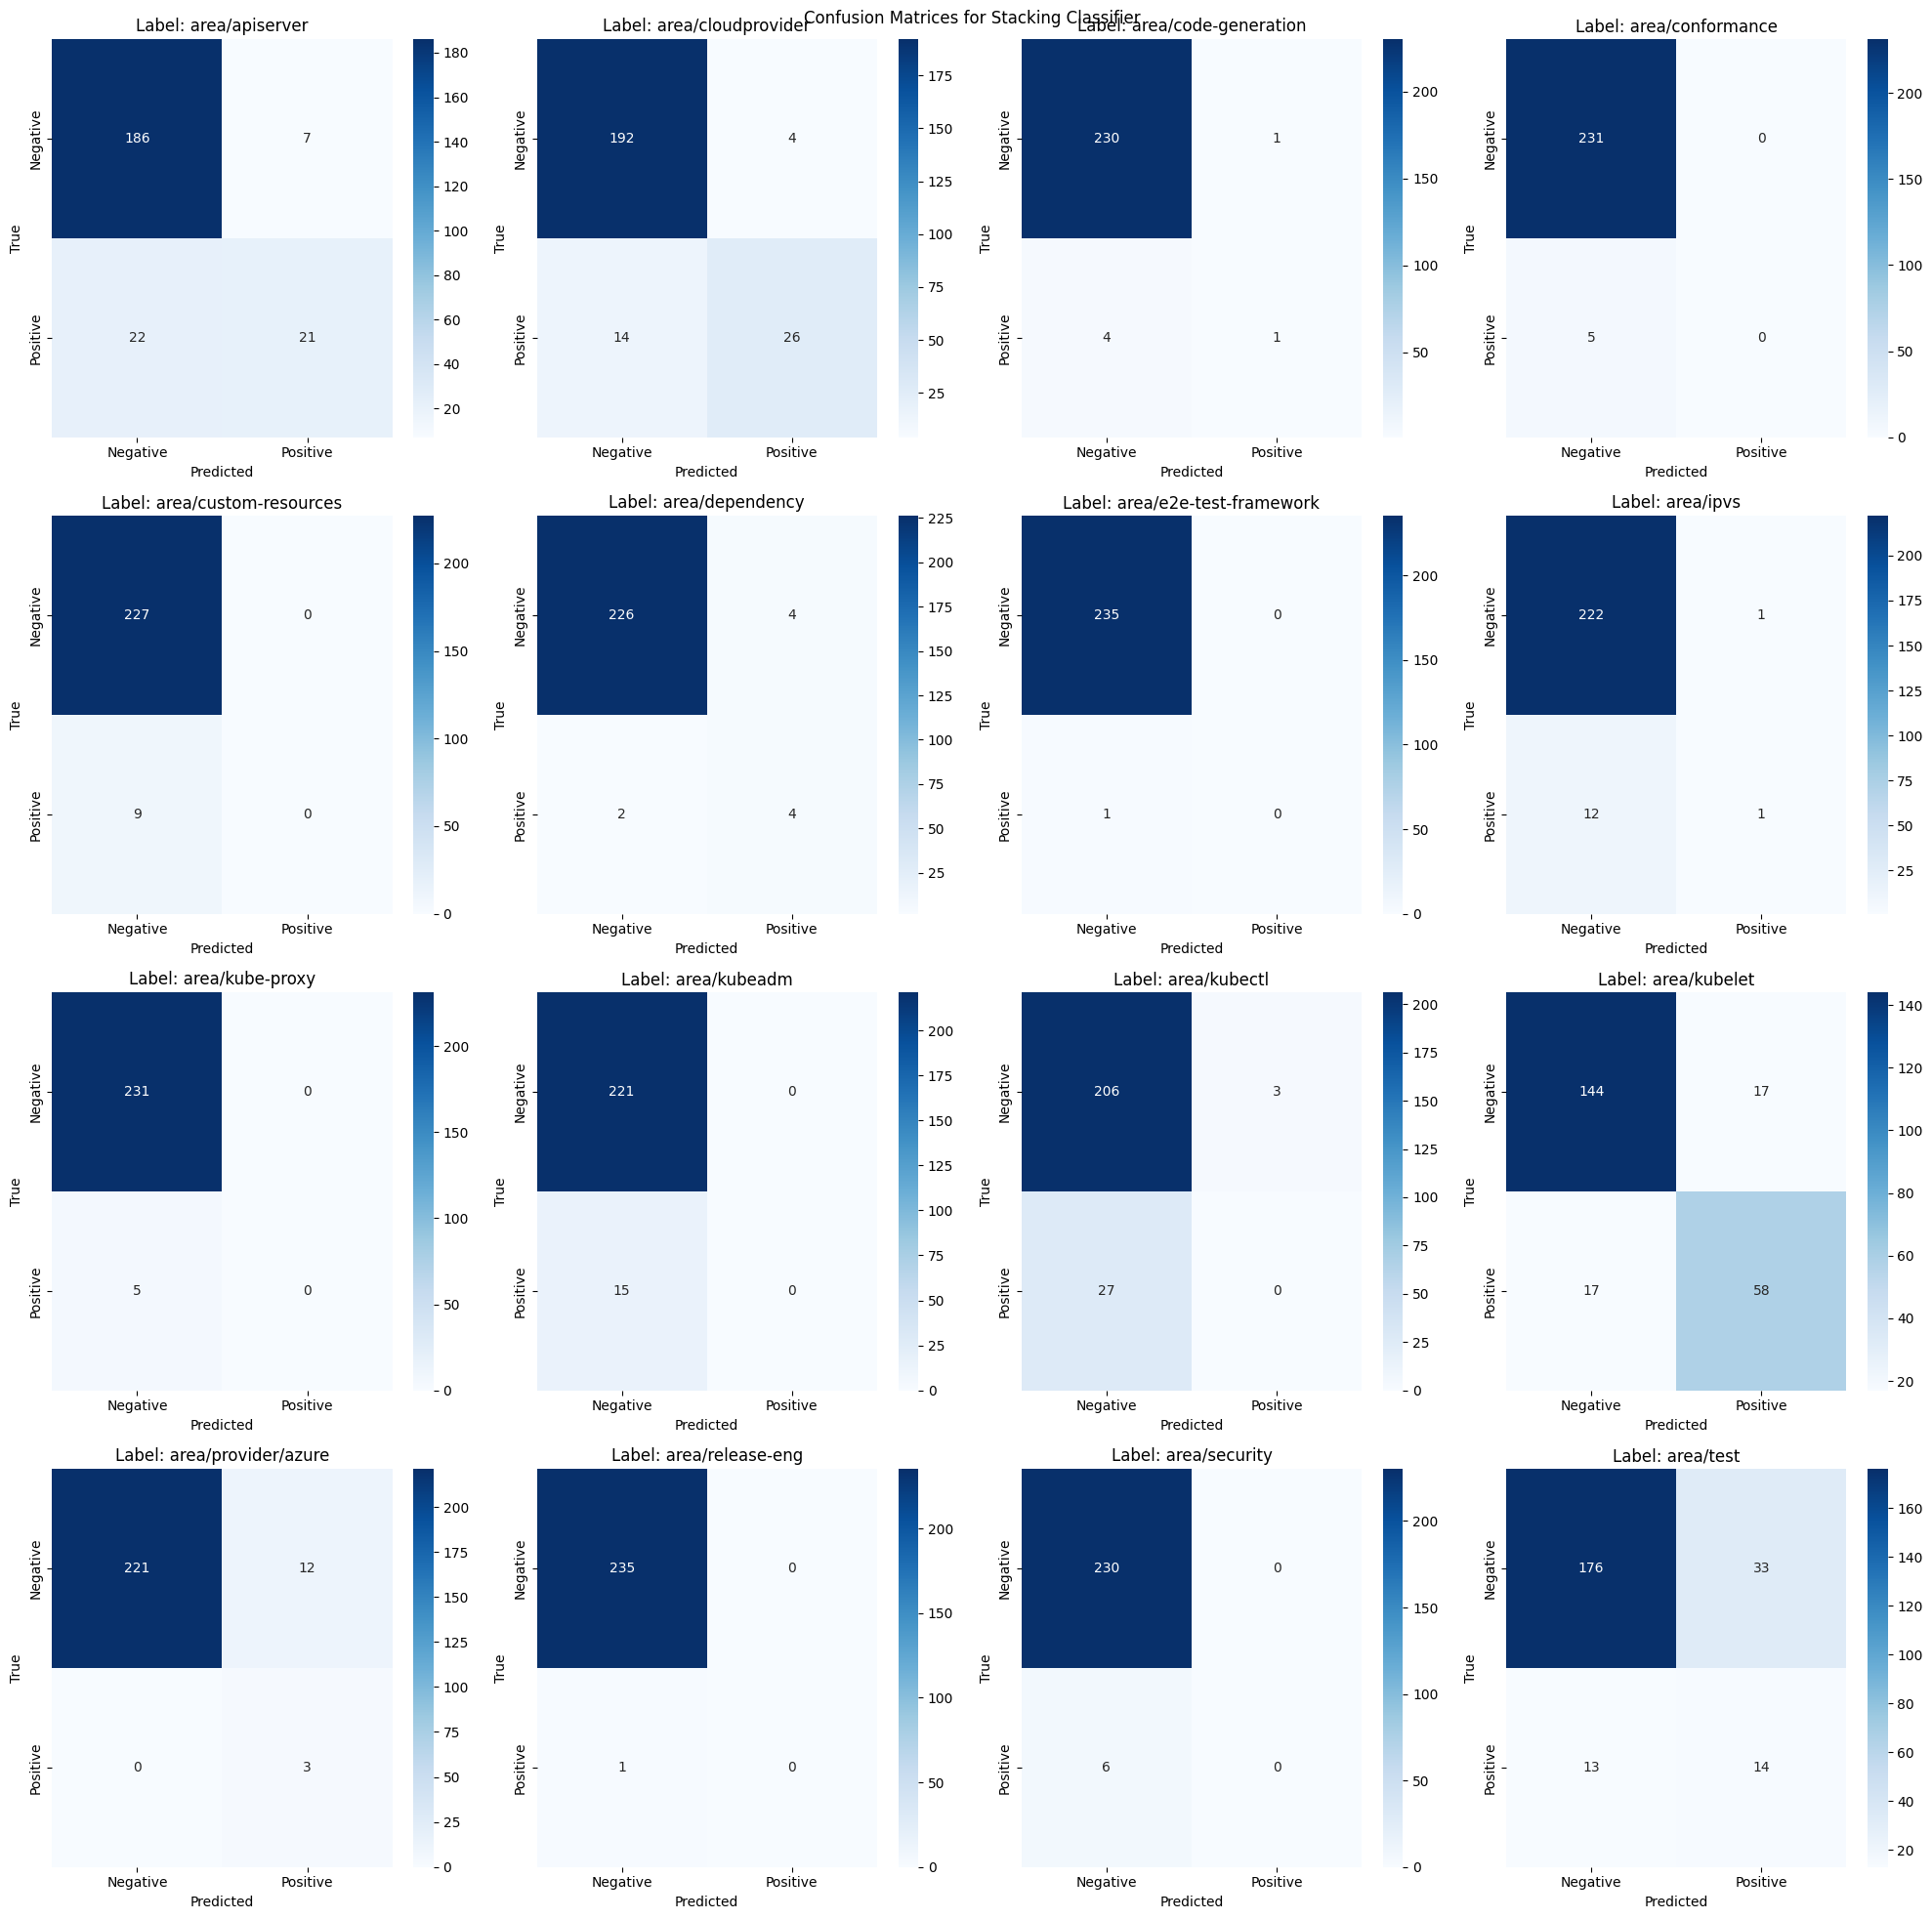

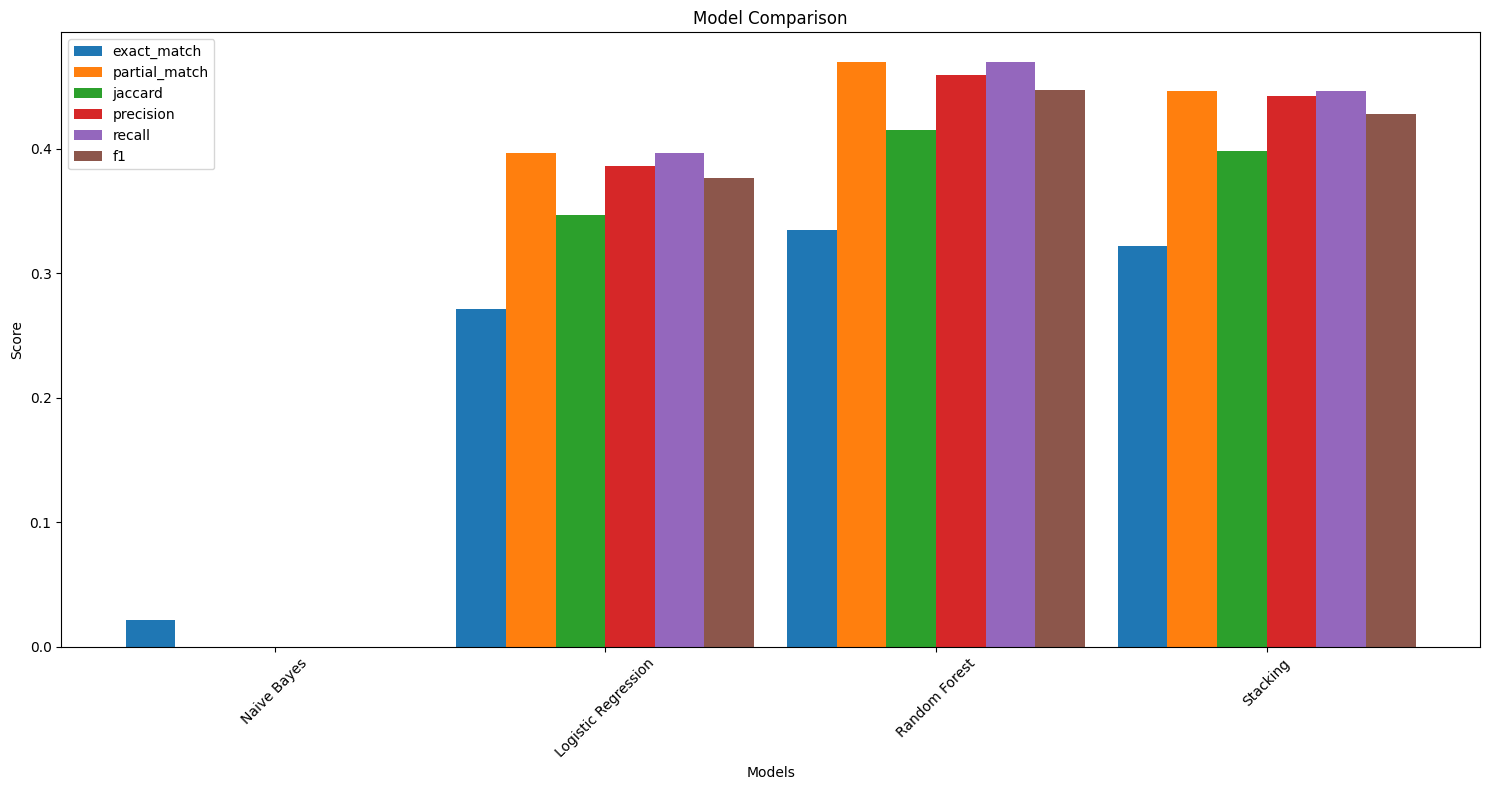

In [33]:
if __name__ == "__main__":
    parser = argparse.ArgumentParser(description='Train multiple ML models with FastText embeddings for multi-label classification')
    
    # Data parameters
    parser.add_argument('--data_path', type=str, 
                        default="/kaggle/input/kubernetes-final-bug-data-without-comments/cleaned_data_with_changed_files_no_comments.json",
                        help='Path to the JSON data file')
    parser.add_argument('--text_column', type=str, default='all_text_0.5',
                        help='Column name with the text data to use for training')
    parser.add_argument('--results_dir', type=str, default='./results',
                        help='Directory to save results')
    parser.add_argument('--fasttext_model_path', type=str, 
                        default='fasttext_model.bin',
                        help='Path to save/load the FastText model')
    
    # Label filtering parameters
    parser.add_argument('--min_label_freq', type=int, default=5,
                        help='Minimum frequency for a label to be considered')
    parser.add_argument('--max_label_len', type=int, default=5,
                        help='Maximum number of labels per sample')
    parser.add_argument('--min_label_comb_freq', type=int, default=2,
                        help='Minimum frequency for a label combination')
    
    # Training parameters
    parser.add_argument('--batch_size', type=int, default=32, help='Batch size for generating embeddings')
    parser.add_argument('--n_estimators', type=int, default=100, help='Number of trees in Random Forest')
    parser.add_argument('--max_depth', type=int, default=None, help='Maximum depth of trees')
    parser.add_argument('--min_samples_split', type=int, default=2, help='Minimum samples required to split')
    parser.add_argument('--min_samples_leaf', type=int, default=1, help='Minimum samples in leaf nodes')
    
    # Parse arguments
    args, unknown = parser.parse_known_args()
    
    # Run the main function
    results = main(args) 